# How to build a linear factor model

Algorithmic trading strategies use linear factor models to quantify the relationship between the return of an asset and the sources of risk that represent the main drivers of these returns. Each factor risk carries a premium, and the total asset return can be expected to correspond to a weighted average of these risk premia.

There are several practical applications of factor models across the portfolio management process from construction and asset selection to risk management and performance evaluation. The importance of factor models continues to grow as common risk factors are now tradeable:

* A summary of the returns of many assets by a much smaller number of factors reduces the amount of data required to estimate the covariance matrix when optimizing a portfolio
* An estimate of the exposure of an asset or a portfolio to these factors allows for the management of the resultant risk, for instance by entering suitable hedges when risk factors are themselves traded
* A factor model also permits the assessment of the incremental signal content of new alpha factors
* A factor model can also help assess whether a manager's performance relative to a benchmark is indeed due to skill in selecting assets and timing the market, or if instead, the performance can be explained by portfolio tilts towards known return drivers that can today be replicated as low-cost, passively managed funds without incurring active management fees

# Imports & Settings

In [ ]:
!pip install linearmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.5 MB/s eta 0:00:00


In [ ]:
# Import the warnings module to handle warning messages
import warnings

# Ignore all warning messages
# This can be useful for suppressing non-critical warnings, but use with caution
# as it might hide important information about your code's behavior
warnings.filterwarnings('ignore')

# Import essential data manipulation libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np   # For numerical operations

# Import statistical modeling tools from statsmodels
from statsmodels.api import OLS, add_constant
# OLS: Ordinary Least Squares for regression analysis
# add_constant: Adds a constant term to a model

# Import web data reader from pandas
import pandas_datareader.data as web
# This allows fetching financial data from various online sources

# Import LinearFactorModel from linearmodels for asset pricing analysis
from linearmodels.asset_pricing import LinearFactorModel

# Import visualization libraries
import matplotlib.pyplot as plt  # For creating static, animated, and interactive visualizations
import seaborn as sns  # For statistical data visualization

# Set the visual style for seaborn plots
# 'whitegrid' adds a white background with grid lines to the plots
sns.set_style('whitegrid')

# Note: Setting a consistent style helps in creating visually appealing and
# easily interpretable plots across your entire analysis

# Get Data

Fama and French make updated risk factor and research portfolio data available through their [website](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html), and you can use the `pandas_datareader` package to obtain the data.

## Risk Factors

In particular, we will be using the five Fama—French factors that result from sorting stocks first into three size groups and then into two for each of the remaining three firm-specific factors.

Hence, the factors involve three sets of value-weighted portfolios formed as 3 x 2 sorts on size and book-to-market, size and operating profitability, and size and investment. The risk factor values computed as the average returns of the portfolios (PF) as outlined in the following table:

| Label | Name | Description |
|-------|------|-------------|
| SMB   | Small Minus Big | Average return on the nine small stock portfolios minus the average return on the nine big stock portfolios |
| HML   | High Minus Low | Average return on the two value portfolios minus the average return on the two growth portfolios |
| RMW   | Robust minus Weak | Average return on the two robust operating profitability portfolios minus the average return on the two weak operating profitability portfolios |
| CMA   | Conservative Minus Aggressive | Average return on the two conservative investment portfolios minus the average return on the two aggressive investment portfolios |
| Rm-Rf | Excess return on the market | Value-weight return of all firms incorporated in the US and listed on the NYSE, AMEX, or NASDAQ at the beginning of month t with 'good' data for t minus the one-month Treasury bill rate |

The Fama-French 5 factors are based on the 6 value-weight portfolios formed on size and book-to-market, the 6 value-weight portfolios formed on size and operating profitability, and the 6 value-weight portfolios formed on size and investment.

We will use returns at a monthly frequency that we obtain for the period 2010 – 2017 as follows:

In [ ]:
# Define the name of the Fama-French dataset we want to retrieve
ff_factor = 'F-F_Research_Data_5_Factors_2x3'

# Use web.DataReader to fetch the Fama-French 5 Factor data
# Parameters:
#   - ff_factor: the name of the dataset
#   - 'famafrench': specifies we're using the Fama-French data source
#   - start='2010': start date for the data
#   - end='2017-12': end date for the data
# The [0] at the end selects the first DataFrame from the returned data structure
ff_factor_data = web.DataReader(ff_factor, 'famafrench', start='2010', end='2017-12')[0]

# Display information about the DataFrame
# This will show the number of rows and columns, column names, and data types
ff_factor_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 96 entries, 2010-01 to 2017-12
Freq: M
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  96 non-null     float64
 1   SMB     96 non-null     float64
 2   HML     96 non-null     float64
 3   RMW     96 non-null     float64
 4   CMA     96 non-null     float64
 5   RF      96 non-null     float64
dtypes: float64(6)
memory usage: 5.2 KB


In [ ]:
ff_factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,RF
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,1.158542,0.060208,-0.050000,0.128333,0.047917,0.012604
std,3.580031,2.301908,2.202886,1.582417,1.412333,0.022583
min,-7.890000,-4.550000,-4.700000,-3.880000,-3.270000,0.000000
25%,-0.917500,-1.702500,-1.662500,-1.090000,-0.952500,0.000000
50%,1.235000,0.205000,-0.310000,0.195000,-0.005000,0.000000
75%,3.197500,1.590000,1.205000,1.197500,0.922500,0.010000
max,11.350000,7.070000,8.210000,3.480000,3.700000,0.090000


## Portfolios

Fama and French also make available numerous portfolios that we can use to illustrate the estimation of the factor exposures, as well as the value of the risk premia available in the market for a given time period. We will use a panel of the 17 industry portfolios at a monthly frequency.

We will subtract the risk-free rate from the returns because the factor model works with excess returns:

In [ ]:
# Define the name of the Fama-French portfolio dataset we want to retrieve
ff_portfolio = '17_Industry_Portfolios'

# Use web.DataReader to fetch the 17 Industry Portfolios data
# Parameters are similar to the previous data retrieval
ff_portfolio_data = web.DataReader(ff_portfolio, 'famafrench', start='2010', end='2017-12')[0]

# Subtract the risk-free rate (RF) from each industry portfolio return
# This converts raw returns to excess returns
ff_portfolio_data = ff_portfolio_data.sub(ff_factor_data.RF, axis=0)

# Display information about the resulting DataFrame
ff_portfolio_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 96 entries, 2010-01 to 2017-12
Freq: M
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Food    96 non-null     float64
 1   Mines   96 non-null     float64
 2   Oil     96 non-null     float64
 3   Clths   96 non-null     float64
 4   Durbl   96 non-null     float64
 5   Chems   96 non-null     float64
 6   Cnsum   96 non-null     float64
 7   Cnstr   96 non-null     float64
 8   Steel   96 non-null     float64
 9   FabPr   96 non-null     float64
 10  Machn   96 non-null     float64
 11  Cars    96 non-null     float64
 12  Trans   96 non-null     float64
 13  Utils   96 non-null     float64
 14  Rtail   96 non-null     float64
 15  Finan   96 non-null     float64
 16  Other   96 non-null     float64
dtypes: float64(17)
memory usage: 13.5 KB


In [ ]:
ff_portfolio_data.describe()

,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,1.035417,0.210000,0.594896,1.383646,1.141771,1.327604,1.189063,1.734167,0.535521,1.350208,1.219271,1.282292,1.469792,0.894271,1.240417,1.247292,1.286250
std,2.805824,7.942856,5.504306,5.007997,5.207729,5.585949,3.141205,5.249994,7.424776,4.713899,4.801381,5.757512,4.167801,3.232446,3.519087,4.868399,3.674353
min,-5.160000,-24.510000,-11.760000,-9.770000,-13.170000,-16.770000,-7.180000,-14.140000,-20.570000,-12.180000,-9.110000,-11.770000,-8.660000,-7.110000,-9.200000,-11.290000,-8.040000
25%,-0.797500,-5.810000,-3.167500,-1.572500,-2.272500,-1.337500,-0.895000,-2.435000,-4.385000,-1.450000,-2.010000,-1.255000,-0.860000,-0.735000,-0.952500,-1.530000,-1.147500
50%,0.940000,-0.480000,0.990000,1.155000,1.225000,1.445000,1.465000,2.160000,0.655000,1.500000,1.495000,0.620000,1.520000,1.275000,0.885000,1.790000,1.570000
75%,3.210000,5.905000,4.195000,3.770000,4.627500,4.437500,3.295000,5.555000,4.270000,3.845000,4.582500,4.815000,4.342500,2.930000,3.367500,4.147500,3.425000
max,6.680000,22.030000,16.030000,17.320000,16.580000,18.360000,8.280000,15.580000,21.620000,17.870000,14.740000,21.040000,13.030000,7.840000,12.460000,13.500000,10.430000


# Equity Data

In [ ]:
# Mount Google Drive, load API keys for Quandl, and set up environment variables for API access
from google.colab import drive
import json

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path
HDF_PATH = Path('drive', 'MyDrive', 'ML4T', 'assets.h5')

In [ ]:
# Open the HDF5 file containing our data
with pd.HDFStore(HDF_PATH) as store:
    # Extract adjusted close prices for the period 2010-2017
    # The 'unstack()' operation transforms the data from long to wide format
    prices = store['/quandl/wiki/prices'].adj_close.unstack().loc['2010':'2017']

    # Extract equity information, removing any duplicate entries
    equities = store['/us_equities/stocks'].drop_duplicates()

# Create a dictionary mapping tickers to their sectors
# We filter the equities to only include those present in our price data
sectors = equities.filter(prices.columns, axis=0).sector.to_dict()

# Filter the price data to only include stocks for which we have sector information
# Drop any columns (stocks) that have all NaN values
prices = prices.filter(sectors.keys()).dropna(how='all', axis=1)

# Calculate monthly returns:
# 1. Resample to monthly frequency, taking the last price of each month
# 2. Calculate percentage change
# 3. Multiply by 100 to get percentage
# 4. Convert the datetime index to period index
returns = prices.resample('M').last().pct_change().mul(100).to_period('M')

# Remove any rows or columns that are all NaN
returns = returns.dropna(how='all').dropna(axis=1)

# Display information about the resulting DataFrame
returns.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 95 entries, 2010-02 to 2017-12
Freq: M
Columns: 1515 entries, A to ZUMZ
dtypes: float64(1515)
memory usage: 1.1 MB


# Align data

In [ ]:
# Align the Fama-French factor data with our returns data
# This ensures that we're only using factor data for the same time periods as our stock returns
ff_factor_data = ff_factor_data.loc[returns.index]

# Similarly, align the Fama-French portfolio data with our returns data
ff_portfolio_data = ff_portfolio_data.loc[returns.index]

# Generate descriptive statistics for the Fama-French factor data
# This includes count, mean, std, min, 25%, 50%, 75%, max for each factor
ff_factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,RF
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,1.206105,0.057263,-0.055053,0.143053,0.043579,0.012737
std,3.568400,2.313938,2.214013,1.584191,1.419182,0.022665
min,-7.890000,-4.550000,-4.700000,-3.880000,-3.270000,0.000000
25%,-0.565000,-1.705000,-1.665000,-0.925000,-0.965000,0.000000
50%,1.290000,0.160000,-0.310000,0.240000,-0.010000,0.000000
75%,3.265000,1.610000,1.220000,1.205000,0.935000,0.010000
max,11.350000,7.070000,8.210000,3.480000,3.700000,0.090000


# Compute excess Returns

In [ ]:
# Calculate excess returns by subtracting the risk-free rate (RF) from each stock's return
# The risk-free rate is taken from the Fama-French factor data
# axis=0 ensures the subtraction is done row-wise (for each time period)
excess_returns = returns.sub(ff_factor_data.RF, axis=0)

# Display information about the resulting excess returns DataFrame
excess_returns.info()

# Clip the excess returns to remove extreme outliers
# This sets all values below the 1st percentile to the 1st percentile value,
# and all values above the 99th percentile to the 99th percentile value
excess_returns = excess_returns.clip(lower=np.percentile(excess_returns, 1),
                                     upper=np.percentile(excess_returns, 99))

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 95 entries, 2010-02 to 2017-12
Freq: M
Columns: 1515 entries, A to ZUMZ
dtypes: float64(1515)
memory usage: 1.1 MB


## Fama-Macbeth Regression

Given data on risk factors and portfolio returns, it is useful to estimate the portfolio's exposure, that is, how much the risk factors drive portfolio returns, as well as how much the exposure to a given factor is worth, that is, what the market's risk factor premium is. The risk premium then permits to estimate the return for any portfolio provided the factor exposure is known or can be assumed.

In [ ]:
ff_portfolio_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 95 entries, 2010-02 to 2017-12
Freq: M
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Food    95 non-null     float64
 1   Mines   95 non-null     float64
 2   Oil     95 non-null     float64
 3   Clths   95 non-null     float64
 4   Durbl   95 non-null     float64
 5   Chems   95 non-null     float64
 6   Cnsum   95 non-null     float64
 7   Cnstr   95 non-null     float64
 8   Steel   95 non-null     float64
 9   FabPr   95 non-null     float64
 10  Machn   95 non-null     float64
 11  Cars    95 non-null     float64
 12  Trans   95 non-null     float64
 13  Utils   95 non-null     float64
 14  Rtail   95 non-null     float64
 15  Finan   95 non-null     float64
 16  Other   95 non-null     float64
dtypes: float64(17)
memory usage: 13.4 KB


In [ ]:
ff_factor_data = ff_factor_data.drop('RF', axis=1)
ff_factor_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 95 entries, 2010-02 to 2017-12
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  95 non-null     float64
 1   SMB     95 non-null     float64
 2   HML     95 non-null     float64
 3   RMW     95 non-null     float64
 4   CMA     95 non-null     float64
dtypes: float64(5)
memory usage: 4.5 KB


To address the inference problem caused by the correlation of the residuals, Fama and MacBeth proposed a two-step methodology for a cross-sectional regression of returns on factors. The two-stage Fama—Macbeth regression is designed to estimate the premium rewarded for the exposure to a particular risk factor by the market. The two stages consist of:

* First stage: N time-series regression, one for each asset or portfolio, of its excess returns on the factors to estimate the factor loadings.
* Second stage: T cross-sectional regression, one for each time period, to estimate the risk premium.

See corresponding section in Chapter 7 of Machine Learning for Trading for details.

Now we can compute the factor risk premia as the time average and get t-statistic to assess their individual significance, using the assumption that the risk premia estimates are independent over time.

If we had a very large and representative data sample on traded risk factors we could use the sample mean as a risk premium estimate. However, we typically do not have a sufficiently long history to and the margin of error around the sample mean could be quite large.

The Fama—Macbeth methodology leverages the covariance of the factors with other assets to determine the factor premia. The second moment of asset returns is easier to estimate than the first moment, and obtaining more granular data improves estimation considerably, which is not true of mean estimation.

## Step 1: Factor Exposures

We can implement the first stage to obtain the 17 factor loading estimates as follows:

In [ ]:
# Step 1: Estimating factor loadings (betas) for each industry portfolio

betas = []
for industry in ff_portfolio_data:
    # For each industry, perform a time-series regression
    step1 = OLS(
        # Dependent variable: excess returns for the industry
        endog=ff_portfolio_data.loc[ff_factor_data.index, industry],
        # Independent variables: Fama-French factors (with a constant term added)
        exog=add_constant(ff_factor_data)
    ).fit()
    # Store the coefficients (excluding the constant term) in the betas list
    betas.append(step1.params.drop('const'))

# Convert the list of betas into a DataFrame
betas = pd.DataFrame(
    betas,
    columns=ff_factor_data.columns,  # Column names are the Fama-French factors
    index=ff_portfolio_data.columns  # Row names are the industries
)
# Display information about the betas DataFrame
betas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, Food  to Other
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  17 non-null     float64
 1   SMB     17 non-null     float64
 2   HML     17 non-null     float64
 3   RMW     17 non-null     float64
 4   CMA     17 non-null     float64
dtypes: float64(5)
memory usage: 1.3+ KB


## Step 2: Risk Premia

For the second stage, we run 96 regressions of the period returns for the cross section of portfolios on the factor loadings

In [ ]:
# Step 2: Estimating risk premia (lambdas) for each time period

lambdas = []
for period in ff_portfolio_data.index:
    # For each time period, perform a cross-sectional regression
    step2 = OLS(
        # Dependent variable: returns for all industries in this period
        endog=ff_portfolio_data.loc[period, betas.index],
        # Independent variables: factor loadings (betas) estimated in Step 1
        exog=betas
    ).fit()
    # Store the coefficients (risk premia) in the lambdas list
    lambdas.append(step2.params)

# Convert the list of lambdas into a DataFrame
lambdas = pd.DataFrame(
    lambdas,
    index=ff_portfolio_data.index,       # Row names are the time periods
    columns=betas.columns.tolist()       # Column names are the Fama-French factors
)
# Display information about the lambdas DataFrame
lambdas.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 95 entries, 2010-02 to 2017-12
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  95 non-null     float64
 1   SMB     95 non-null     float64
 2   HML     95 non-null     float64
 3   RMW     95 non-null     float64
 4   CMA     95 non-null     float64
dtypes: float64(5)
memory usage: 6.5 KB


## Results

Now let's visualize the results of our Fama-MacBeth regression:

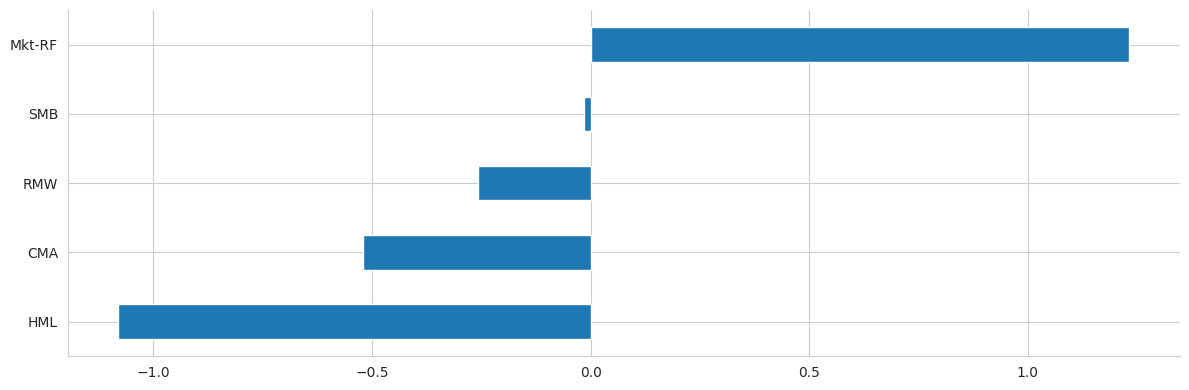

In [ ]:
# Plot the mean risk premia for each factor
lambdas.mean().sort_values().plot.barh(figsize=(12, 4))
sns.despine()
plt.tight_layout()

In [ ]:
# Calculate t-statistics for the risk premia
t = lambdas.mean().div(lambdas.std())
t

,0
Mkt-RF,0.343434
SMB,-0.003835
HML,-0.266627
RMW,-0.085903
CMA,-0.147695


## Detailed Results

Let's now look at how the risk premia evolve over time:

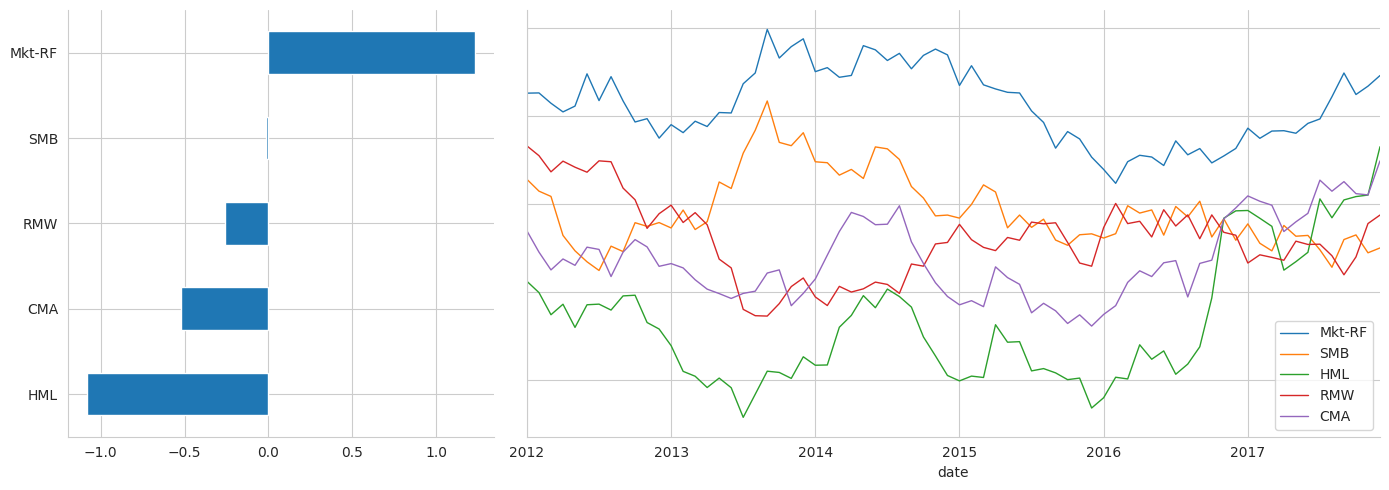

In [ ]:
# Set the window size for rolling average calculation
window = 24  # months

# Create a figure with 3 subplots, with custom width ratios
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5),
                                    gridspec_kw={'width_ratios': [1, 2]})

# Plot average risk premia
lambdas.mean().sort_values().plot.barh(ax=ax1)

# Plot rolling average of risk premia over time
lambdas.rolling(window).mean().dropna().plot(lw=1, ax=ax2, sharey=True)

# Customize the plot
ax2.set_ylabel('')
sns.despine()
plt.tight_layout()

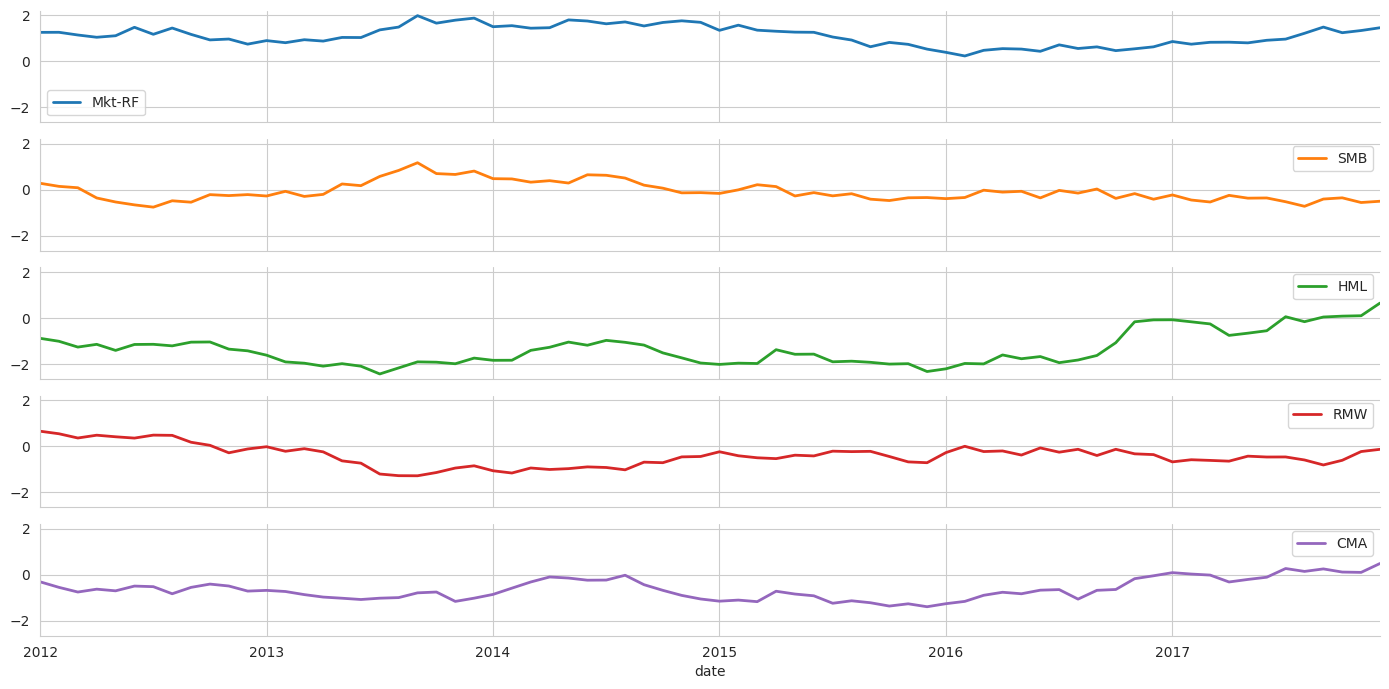

In [ ]:
# Create individual plots for each factor's risk premium over time
window = 24  # months
lambdas.rolling(window).mean().dropna().plot(lw=2,
                                             figsize=(14, 7),
                                             subplots=True,
                                             sharey=True)
sns.despine()
plt.tight_layout()

## Fama-MacBeth with the LinearModels library

The linear_models library extends statsmodels with various models for panel data and also implements the two-stage Fama—MacBeth procedure:

In [ ]:
# Implement Fama-MacBeth regression using LinearFactorModel
mod = LinearFactorModel(portfolios=ff_portfolio_data,
                        factors=ff_factor_data)
res = mod.fit()
print(res)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 17   R-squared:                      0.6897
No. Factors:                          5   J-statistic:                    15.930
No. Observations:                    95   P-value                         0.1944
Date:                  Fri, Aug 02 2024   Distribution:                 chi2(12)
Time:                          06:36:36                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         1.2322     0.4067     3.0298     0.0024      0.4351      2.0294
SMB           -0.0150     0.8667    

In [ ]:
# Print the full summary of results
print(res.full_summary)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 17   R-squared:                      0.6897
No. Factors:                          5   J-statistic:                    15.930
No. Observations:                    95   P-value                         0.1944
Date:                  Fri, Aug 02 2024   Distribution:                 chi2(12)
Time:                          06:36:36                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         1.2322     0.4067     3.0298     0.0024      0.4351      2.0294
SMB           -0.0150     0.8667    

In [ ]:
# Compare results with our manual calculation
lambdas.mean()

,0
Mkt-RF,1.232239
SMB,-0.014996
HML,-1.080202
RMW,-0.257129
CMA,-0.519644
